STUDENT: JOAN ROSSELLO BOVER

In [1]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (12.0, 10.0)
from scipy.linalg import null_space # --> we use this if we want to use 4 points intead of 5 when calculating a Homography

# Part H: Tracking and Homographies

In this part we use Practical 9c to track the positions of the four corners of the square and project a cube into the images. 

TO DO: QUESTIONS TO THINK ABOUT...

- Do the results look realistic? 
- If not then what factors do you think might be causing this


TO DO: your routines for computing a homography and extracting a valid rotation and translation go in the code below. Tips:
- you may define functions for T and H matrices respectively.
- you may need to turn the points into homogeneous form before any other computation. 
- you may need to solve a linear system in Ah = 0 form. Write your own routines or using the builtin function 'svd'. 
- you may apply the direct linear transform (DLT) algorithm to recover the best homography H.
- you may explain what & why you did in the report.


In [2]:
#Likelihood function is simple patch similarity

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    # likelihood = cv.matchTemplate(image[:,:,2], template, methods[0])
    # (You can also try converting the image to greyscale instead of using the third channel as above with 
    # cv.cvtColor(image, cv.COLOR_BGR2GRAY))
    likelihood = cv.matchTemplate(image, template, methods[0]) # images have been converted to greyscale
    
    #we can pad to make this the size of the input image (for easier indexing)   
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # apply a 10x10 averaging filter for stability. You can experiment with different sizes. 
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

In [3]:
# TO DO: Copy and paste the function HW2_Practical9c in here. 
# Note that the plotting parts have been left on comment. We are just interested in the r array this time. We already know how
# the filter works from HW2_Practical9c.

def HW2_Practical9c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    # print('We are matching this template with shape: ', template.shape)
    # plt.imshow(template)
    # plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.cvtColor(cv.imread(folder+frameNum), cv.COLOR_BGR2GRAY)) # convert images to greyscale
        iFrame += 1
    # plot first image 
    # plt.imshow(images[0])
    # plt.show()

    imgHeight, imgWidth = images[0].shape
    numParticles = 2000
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples) #replace this 

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================

    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w))

    for iTime in range(iFrame): # for iTime in range(iFrame):
        # print('Processing Frame', iTime)
        # TO DO: compute the cumulative sume of the weights. [done]
        cum_hist_of_weights = np.cumsum(weight_of_samples, axis=0) # replace this
        #print(weight_of_samples)


        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        #plt.title('Cumulative histogram of probabilities for sorted list of particles')
        #plt.plot(np.zeros(numParticles), some_threshes,'b.')
        #plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        #which_sample_ids = np.unique(samples_to_propagate)
        #how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        #for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        #plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        #plt.ylabel('Cumulative probability');
        #plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        particles_old = particles_old[samples_to_propagate,:]
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            particles_new[particleNum, :] =  particles_old[particleNum, :] + np.random.normal(0, 20, particles_old.shape[1]) # replace this 
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)

        #plot results
        # f, axarr = plt.subplots(1, 2)
        # axarr[0].imshow(images[iTime])
        # axarr[0].set_title('Particles')
        # # now draw the particles onto the image
        # axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

        # #plot the likelihood
        # axarr[1].imshow(likelihood)
        # axarr[1].set_title('Likelihood')


        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        weight_of_samples = weight_of_samples / np.sum(weight_of_samples) # replace this
        
        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        # axarr[1].plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
        # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
        # of the template. We want to plot the centre of the template - i.e. where the corner we want to identify is.
        # This is the single best scoring particle at position -1 in argsort.
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        # print(r[iTime,:])   
        # plt.show()
        # note that here we are just approximating where the corner is within the template. but it's not exactly at the centre of the
        # template. that's why the 'x' might not be spot on the corner in our plots, but they will be at the position matching
        # the middle of the template.

        #print the original image and the position of the tracked corner (MAP).
        # plt.imshow(images[iTime])
        # plt.plot(r[iTime,0],r[iTime,1],'rx')
        # plt.show()
        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

In [4]:
# instead of running the code here, you can also save the output of each function in a numpy array in HW2_Practical9c 
# and load it here. This could be handy if you need different hyperparameters for each corner.

# LLs = HW2_Practical9c( 'll' )
# LRs = HW2_Practical9c( 'lr' )
# ULs = HW2_Practical9c( 'ul' )
# URs = HW2_Practical9c( 'ur' )

In [5]:
# save arrays so that we don't have to compute them again
# np.savetxt('LLs.txt', LLs, fmt='%d')
# np.savetxt('LRs.txt', LRs, fmt='%d')
# np.savetxt('ULs.txt', ULs, fmt='%d')
# np.savetxt('URs.txt', URs, fmt='%d')

In [6]:
# load arrays
LLs = np.loadtxt('LLs.txt', dtype=int)
LRs = np.loadtxt('LRs.txt', dtype=int)
ULs = np.loadtxt('ULs.txt', dtype=int)
URs = np.loadtxt('URs.txt', dtype=int)

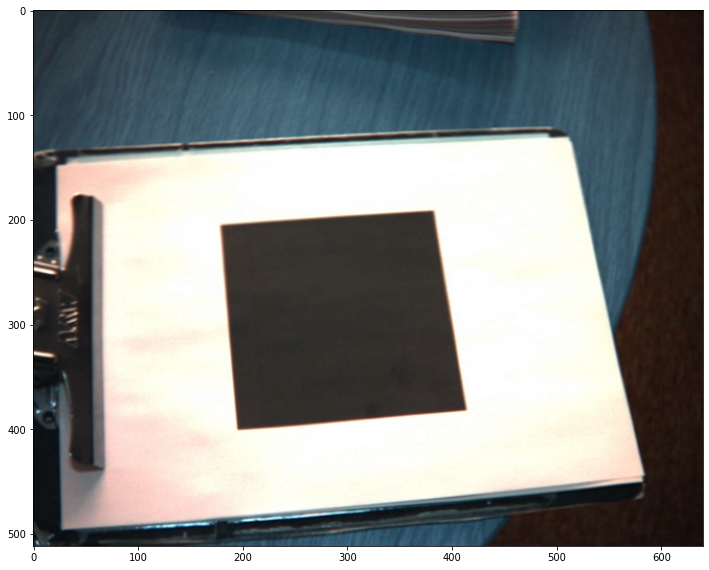

In [7]:
# Load all images in folder
images = []
nFrame = 0
folder = 'Pattern01/'
lst = os.listdir(folder)
lst.sort()

for frameNum in lst:
    images.append(cv.imread(folder+frameNum))
    nFrame += 1
# plot first image 
plt.imshow(images[0])
plt.show()


# Coordinates of the known target object (a dark square on a plane) in 3D: --> here we add an extra point at the centre of the cube
XCart = np.array([[-50, -50,  50,  50],
                  [ 50, -50, -50,  50],
                  [  0,   0,   0,   0]])

# XCart = np.array([[-50, -50,  50,  50, 0],
#                   [ 50, -50, -50,  50, 0],
#                   [  0,   0,   0,   0, 0]])

# These are some approximate intrinsics for this footage.
K = np.array([[640, 0, 320],
          [0, 512, 256],
            [0, 0, 1]])

# Define 3D points of wireframe object --> note that we have added two extra points so that when we connect the points
# it draws a cube, and then we will add the missing lines.
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50, -50,  50,  50, -50],
                           [50, -50, -50,  50, 50, 50, -50, -50,  50, 50],
                           [0,   0,   0,   0, 0, -100, -100, -100, -100, -100]])

In [8]:
# This function is already defined in Practical 2A

def projectiveCamera(K,T,XCart):
    ##TODO
    # The goal of this function is to project points in XCart through projective camera
    # defined by intrinsic matrix K and extrinsic matrix T. In essence, this function takes a set of points 
    # in 3D world space, XCart, and projects them into camera image space by applying the extrinsic matrix T 
    # and then applying the intrinsic matrix K.
    # 
    # There are three steps.
    # 1) Move from world space to camera space. 
    #            camera space points = extrinsics T * world space points 
    #
    # 2) Applying the intrinsics matrix to the camera space points after normalizing
    #           homogeneous image space points = K * normalized camera space points
    # 
    # 3) Move to image space cartesian points from image space homogeneous points, involves a 
    # normalization using the third row.
    
    # Note that we use T = (4x4) and K = (3x3)
    
    # TO DO: Replace this
    # XImCart = []

    # TO DO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    XHom = np.concatenate((XCart, np.ones((1,XCart.shape[1]))), axis=0)
    
    # TO DO: Apply extrinsic matrix to XHom, to move to frame of reference of camera
    XImHom = T @ XHom
    
    # TO DO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    XImHom = XImHom[0:3,:]
    
    # TO DO: Move points to image coordinates xImHom by applying intrinsic matrix
    XImHom = K @ XImHom
    
    # TO DO: Convert points back to Cartesian coordinates XImCart
    XImCart = XImHom[0:2,:] / np.tile([XImHom[2,:]],(2,1))
    
    return XImCart


In [9]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 

    _, _, Vt = np.linalg.svd(A, full_matrices=True)
    V = np.transpose(Vt)
    h = V[:,-1].reshape((A.shape[-1],1)) # h0
  
    return h

In [10]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    # H = np.identity(3) ??? - not necessary

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    A = np.zeros([n_points * 2, 9])

    x = pts2Hom[0,:]
    y = pts2Hom[1,:]
    u = pts1Hom[0,:]
    v = pts1Hom[1,:]

    for i in range(n_points):

        A[2*i,:] = np.array([[0, 0, 0, -u[i], -v[i], -1, y[i]*u[i], y[i]*v[i], y[i]]])
        A[2*i+1,:] = np.array([[u[i], v[i], 1, 0, 0, 0, -x[i]*u[i], -x[i]*v[i], -x[i]]])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    if n_points == 4:
        h = null_space(A)
    else:
        h = solveAXEqualsZero(A)
    
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h, (3,3))

    
    return H

In [11]:
def estimatePlanePose(XImCart,XCart,K):
    # The goal of this function is to estimate the pose of a plane relative to camera (extrinsic matrix)
    # given points in image space xImCart, points in 3D world space XCart, and an intrinsics matrix K.
    
    # TO DO: replace this
    # T = []

    # TO DO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    # TO DO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.linalg.inv(K) @ XImHom
    
    # TO DO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    XCamCart = XCamHom[0:2,:] / np.tile([XCamHom[2,:]],(2,1))
    H = calcBestHomography(XCart, XCamCart)
    
    # TO DO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd    
    U, L, Vt = np.linalg.svd(H[:,:2], full_matrices=True)
    R = np.zeros([3,3])
    R[:,:2] = U @ np.eye(3,2) @ Vt

    # TO DO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R[:,-1] = np.cross(R[:,0], R[:,1])
        
    # TO DO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    if np.linalg.det(R) < 0:
        R[:,-1] *= -1

    # TO DO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    k = np.mean(H[:,:2] / R[:,:2])
    t = H[:,-1] / k
    
    # TO DO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if t[-1] < 0:
        t *= -1
        R[:,:2] *= -1
 
            
    # TO DO: Assemble transformation into matrix form
    t = np.reshape(t, (len(t), 1))
    T = np.concatenate((R, t), axis=1)
    vecHom = np.array([[0,0,0,1]])
    T = np.concatenate((T, vecHom), axis=0)

    
    return T 

Define a function that finds the intersection between two lines in case we want to find a 5th point at the centre of the square, where the two diagonals intersect.

In [12]:
def line_intersection(line1, line2): # each line has a point coordinate in every row
    xdiff = (line1[0,0] - line1[1,0], line2[0,0] - line2[1,0])
    ydiff = (line1[0,1] - line1[1,1], line2[0,1] - line2[1,1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

# line1 = np.array([[0,0],[9,6]])
# line2 = np.array([[3,6],[6,0]])

# x, y = line_intersection(line1, line2)

# print(x,y)

Note that some of the following commented code is just in case we want to calculate the homography with 5 points instead of 4, although it might not be the best idea since the 5th point (middle of the square --> intersection of diagonals) would be an approximation from the approximate corner locations we calculated with the function defined in HW2_Practical9c.

Frame number 0


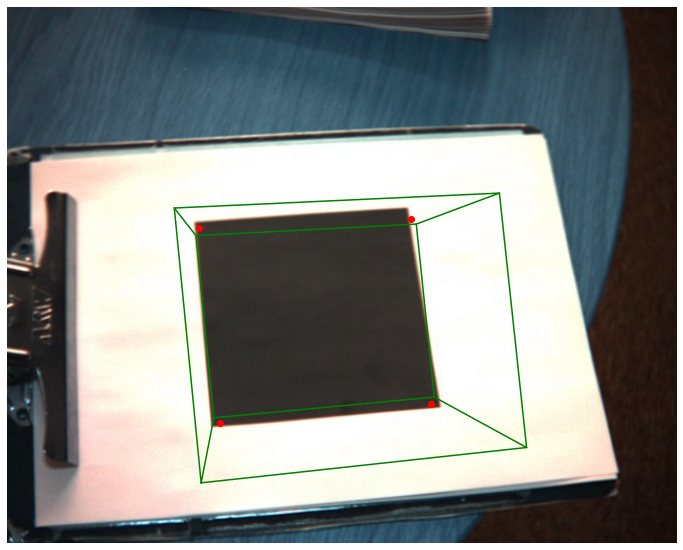

Frame number 1


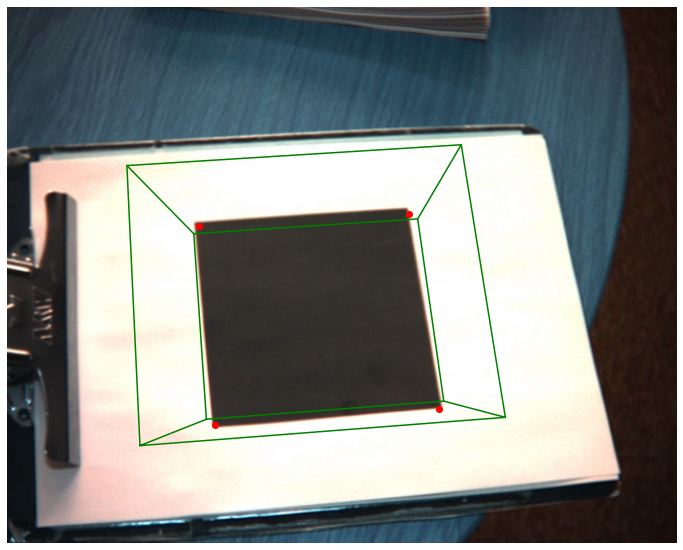

Frame number 5


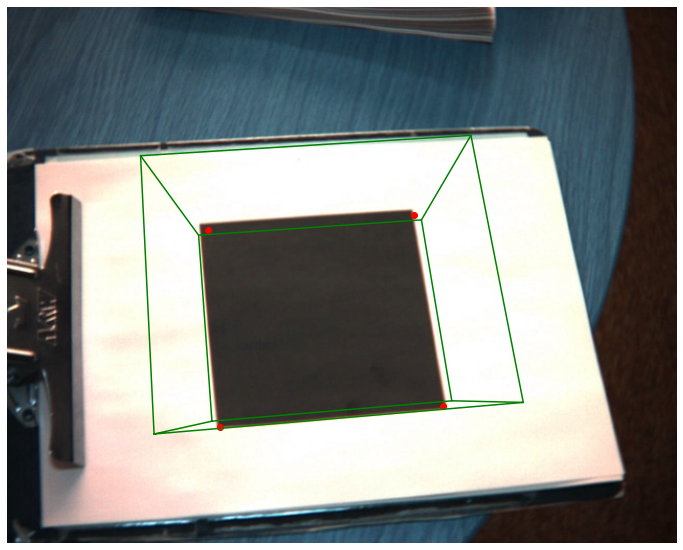

Frame number 50


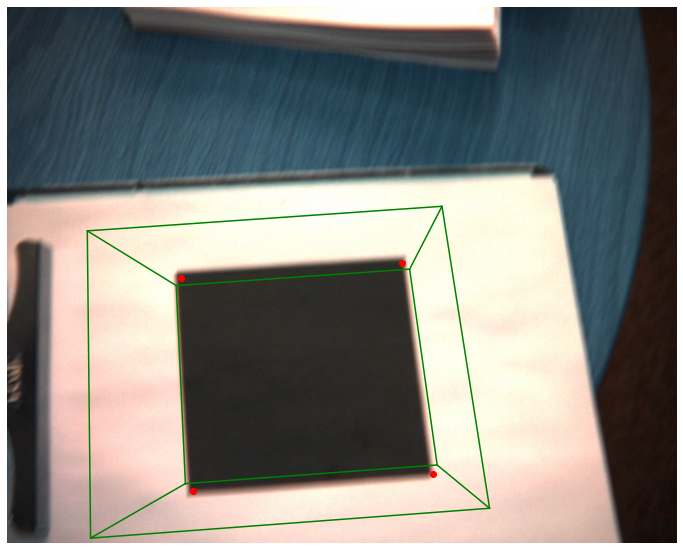

Frame number 100


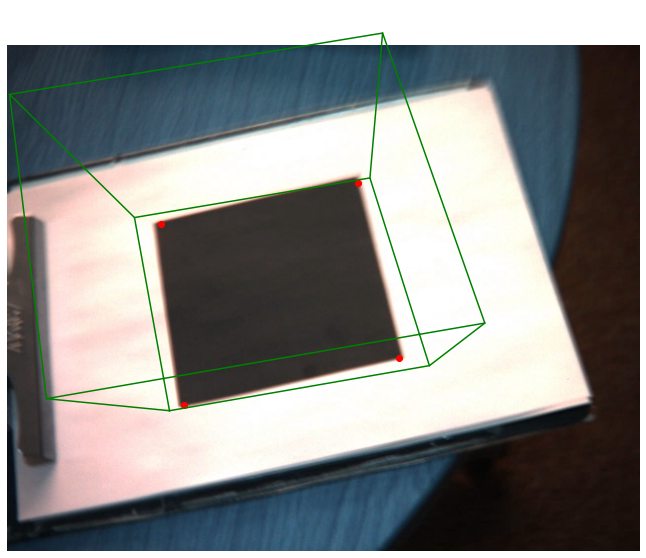

Frame number 150


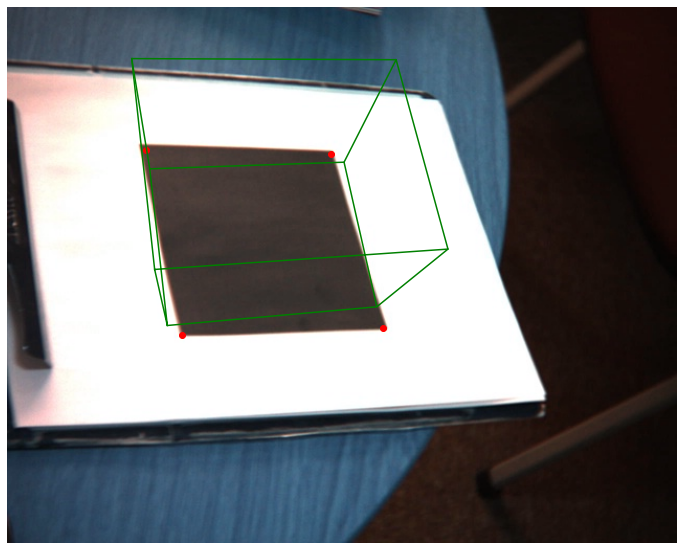

In [13]:
# ================================================
for iFrame in range(nFrame): # for iFrame in range(nFrame):
    
    # line1 = np.array([LLs[iFrame,:], URs[iFrame,:]])
    # line2 = np.array([ULs[iFrame,:], LRs[iFrame,:]])
    # x, y = line_intersection(line1, line2)
    # centre = np.array([[x, y]])

    xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

    # xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T, centre[0,:].T]).T

    # get a frame from footage 
    im = images[iFrame]
    

    # Draw image and 2d points
    if iFrame == 0 or iFrame == 1 or iFrame == 5 or iFrame == 50 or iFrame == 100 or iFrame == nFrame-1: # only plot a few frames
        plt.imshow(im)
        plt.scatter(x = xImCart[0,:], y = xImCart[1,:],c = 'r')
        # plt.show()


    #TO DO: Use your routine to calculate TEst the extrinsic matrix relating the
    #plane position to the camera position.
    #T = estimatePlanePose(xImCart, XCart, K);
    TEst = estimatePlanePose(xImCart,XCart,K)

    
    # TO DO: Draw a wire frame cube using data XWireFrameCart. You need to
    # 1) project the vertices of a 3D cube through the projective camera;
    XWireFrameCartProjected = projectiveCamera(K,TEst,XWireFrameCart)

    # 2) draw lines betweeen the resulting 2d image points.
    l1 = np.array([[-50, -50], [-50, -50], [0, -100]])
    l2 = np.array([[50, 50], [-50, -50], [0, -100]])
    l3 = np.array([[50, 50], [50, 50], [0, -100]])

    l1Proj = projectiveCamera(K,TEst,l1)
    l2Proj = projectiveCamera(K,TEst,l2)
    l3Proj = projectiveCamera(K,TEst,l3)

    # Note: CONDUCT YOUR CODE FOR DRAWING XWireFrameCart HERE
    if iFrame == 0 or iFrame == 1 or iFrame == 5 or iFrame == 50 or iFrame == 100 or iFrame == nFrame-1: # only plot a few frames
        # plt.imshow(im)
        # plt.plot(xImCart[0,],xImCart[1,],'r.')
        print(f'Frame number {iFrame}')
        plt.plot(XWireFrameCartProjected[0,],XWireFrameCartProjected[1,],'g-')
        plt.plot(l1Proj[0,],l1Proj[1,],'g-')
        plt.plot(l2Proj[0,],l2Proj[1,],'g-')
        plt.plot(l3Proj[0,],l3Proj[1,],'g-')
        plt.axis('off')
        plt.show()
    


We have plotted frames 0, 1, 5, 50, 100 and 150 of the moving video of the black square. It is apparent that the camera moves and so the position of the corners of the black square in the image change from frame to frame. Therefore, the projected cube in the image and its perspective should also change along with the square and the angle from which the camera captures the square.

This is the case in the early frames, where the green cube matches the black square pretty well and has a believable perspective in accordance with the orientation of the camera. There are some small inaccuracies:
1) In the early frames, the red dots do not exactly match the black square corners because the particle filter hasn't had the chance to converge yet.
2) The green corners at the base of the cube d not exactly match the red dots, but that can be attributed to the TEst matric not being completely accurate, which is already explained at the end of practical2B of Homographies.

In the latter frames, the results become more and more unrealistic (as shown in frames 100 and 150). The red dots still match the corners of the black square (meaning the particle filter works), but the projected cube does not match the balck square, not with its base nor with its perspective. It seems to have an odd scale and orientation. This could be attributed to the fact that the camera is not re-calibrated thoughout the entirety of the 151 frames. We re-calculate the extrinsics matrix TEst at every frame, but the intrinsics matrix K remains the same as the one we are given at the beginning. If we updated the K matrix (intrinsic parameters of the camera) every 50 frames, for example, maybe that could sort this isse or at least improve the results.